In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import glob
import sys
import os

In [3]:
filenamepaths = glob.glob("./data/validationset/*.png")
filenamepaths[:10]

['./data/validationset/cricket_09879.png',
 './data/validationset/cricket_09553.png',
 './data/validationset/bee_09121.png',
 './data/validationset/cricket_09810.png',
 './data/validationset/cricket_09656.png',
 './data/validationset/noise_09954.png',
 './data/validationset/cricket_09671.png',
 './data/validationset/bee_09354.png',
 './data/validationset/bee_09277.png',
 './data/validationset/cricket_09903.png']

In [4]:
name_to_numeric = {"bee" : 0, "cricket" : 1, "noise" : 2}

def get_class_from_path(path):
    class_name = (os.path.split(path)[-1]).split('_')[0]
    numerical_class = name_to_numeric[class_name]
    return numerical_class

In [5]:
labels = list(map(get_class_from_path, filenamepaths))

In [6]:

for pathname, classname in zip (filenamepaths[:10], labels[:10]):
    print("{} {}".format(classname, pathname))
    

1 ./data/validationset/cricket_09879.png
1 ./data/validationset/cricket_09553.png
0 ./data/validationset/bee_09121.png
1 ./data/validationset/cricket_09810.png
1 ./data/validationset/cricket_09656.png
2 ./data/validationset/noise_09954.png
1 ./data/validationset/cricket_09671.png
0 ./data/validationset/bee_09354.png
0 ./data/validationset/bee_09277.png
1 ./data/validationset/cricket_09903.png


In [7]:
def parse_image_function(filename, label):
    image_string = tf.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_png(image_string, channels=1)

    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize is not actually needed but it is good to have the image dimensions in the
    # Tensor shape
    image = tf.image.resize_images(image, [100, 100])
    return image, label

In [8]:
BATCH_SIZE=100

In [9]:
reset_graph()

The dataset is formed by tuples where the first element is the encoded image and the second is the class

In [10]:
def get_train_inputs(filenames, labels, batch_size, parallel_tasks=4):
    num_samples = len(filenames)
    assert len(filenames) == len(labels), "Filenames and labels should have same length"
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(filenames), tf.constant(labels)))
    dataset = dataset.map(parse_image_function, num_parallel_calls=4)
#     dataset = dataset.shuffle()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    
    iterator = dataset.make_initializable_iterator()
    images, labels = iterator.get_next()
    iterator_init_op = iterator.initializer
    
    inputs = {'images': images, 'labels': labels, 'iterator_init_op': iterator_init_op}
    return inputs
    
train_inputs = get_train_inputs(filenamepaths, labels, BATCH_SIZE)
train_inputs

{'images': <tf.Tensor 'IteratorGetNext:0' shape=(?, 100, 100, 1) dtype=float32>,
 'iterator_init_op': <tf.Operation 'MakeIterator' type=MakeIterator>,
 'labels': <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int32>}

Run a simple iteration to see if the labels are actually changing

In [11]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    sess.run(train_inputs['iterator_init_op'])
    print(sess.run(train_inputs['labels']))
    print(sess.run(train_inputs['labels']))
    print(sess.run(train_inputs['labels']))

[1 1 0 1 1 2 1 0 0 1 0 1 0 1 0 0 2 0 2 2 1 2 2 1 1 2 0 2 0 1 1 1 0 2 1 2 2
 2 0 1 2 2 2 1 1 0 0 0 0 1 1 1 0 0 2 2 2 1 1 1 2 2 2 0 1 0 0 1 1 1 2 0 1 1
 1 2 1 1 2 2 0 2 1 0 2 0 0 0 1 1 0 0 1 0 0 2 1 2 1 1]
[0 2 1 0 2 2 2 1 1 0 1 2 1 0 2 1 2 0 2 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1 2
 1 1 1 0 2 0 1 1 0 1 1 1 1 2 1 2 1 0 0 0 0 2 1 1 1 2 2 2 2 0 1 0 0 0 1 0 1
 0 1 2 2 2 0 1 2 2 1 0 1 0 2 0 2 2 1 1 2 1 2 1 2 1 0]
[2 1 1 2 0 2 0 0 1 1 1 0 0 1 0 2 1 2 1 2 1 1 1 1 1 2 1 2 0 1 1 0 2 2 0 0 1
 1 0 0 0 2 2 1 2 1 2 2 2 0 1 1 1 1 0 1 1 2 0 1 1 2 1 0 1 1 1 2 0 1 2 1 1 0
 1 1 2 1 0 2 1 1 0 1 1 2 2 2 1 1 1 2 0 0 1 2 1 2 0 2]


In [12]:
# a simple model, just a perceptron
images = train_inputs["images"]

flatten_images = tf.reshape(images, [-1, 100*100])

dense1 = tf.layers.dense(
    flatten_images,
    100,
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11)
)

dense2 = tf.layers.dense(
    dense1,
    3,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11)
)


logits=dense2
logits.shape




TensorShape([Dimension(None), Dimension(3)])

In [15]:
labels = train_inputs['labels']
labels = tf.cast(labels, tf.int64)
predictions = tf.argmax(logits,1)

print(predictions.shape)  # should be (?, )

loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
optimizer = tf.train.GradientDescentOptimizer(0.005)
train_op = optimizer.minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, predictions), tf.float32))


(?,)


In [28]:
init = tf.global_variables_initializer()

metrics = {'accuracy_train' : [], 'accuracy_test' : [], 'loss_train' : [], 'loss_test': []}

NUM_EPOCHS=10

with tf.Session() as sess:
    init.run()
    
    # actual training
    for epoch in range(NUM_EPOCHS):
        print("Epoch {}".format(epoch))
        # restart from beginning of the dataset
        sess.run(train_inputs['iterator_init_op'])
        for batch_index in range(len(filenamepaths)//BATCH_SIZE):
            train_op_res, loss_val, accuracy_val = sess.run([train_op, loss, accuracy])
            metrics['accuracy_train'].append(accuracy_val)
            metrics['loss_train'].append(loss_val)
            
            print("{}:{} Train Loss: {}".format(epoch,batch_index,loss_val))
            print("{}:{} Train Acc: {}".format(epoch,batch_index,accuracy_val))
            print()

Epoch 0
0:0 Train Loss: 2.9093410968780518
0:0 Train Acc: 0.3100000023841858

0:1 Train Loss: 5.285609245300293
0:1 Train Acc: 0.41999998688697815

0:2 Train Loss: 7.717114448547363
0:2 Train Acc: 0.28999999165534973

0:3 Train Loss: 5.694516658782959
0:3 Train Acc: 0.4399999976158142

0:4 Train Loss: 4.037654876708984
0:4 Train Acc: 0.23000000417232513

0:5 Train Loss: 4.137662887573242
0:5 Train Acc: 0.20999999344348907

0:6 Train Loss: 7.296288967132568
0:6 Train Acc: 0.46000000834465027

0:7 Train Loss: 1.10015070438385
0:7 Train Acc: 0.5

0:8 Train Loss: 1.8355720043182373
0:8 Train Acc: 0.36000001430511475

0:9 Train Loss: 3.7652008533477783
0:9 Train Acc: 0.41999998688697815

0:10 Train Loss: 3.3806607723236084
0:10 Train Acc: 0.27000001072883606

Epoch 1
1:0 Train Loss: 3.45731782913208
1:0 Train Acc: 0.3199999928474426

1:1 Train Loss: 4.276937961578369
1:1 Train Acc: 0.41999998688697815

1:2 Train Loss: 2.317415475845337
1:2 Train Acc: 0.23999999463558197

1:3 Train Loss: 2.1

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

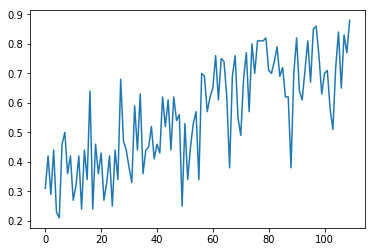

In [31]:
values = metrics['accuracy_train']
plt.plot(range(len(values)), values)

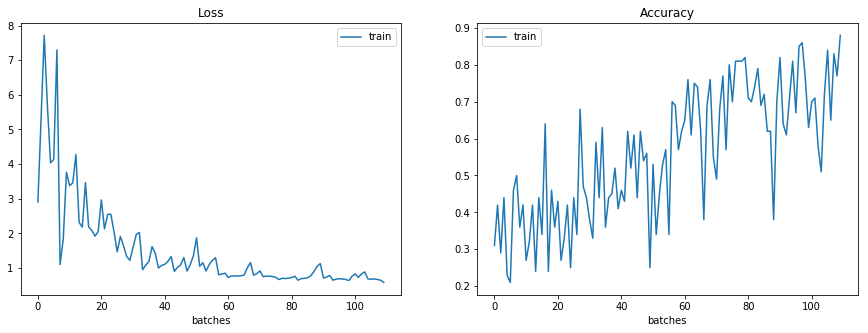

In [51]:
def plot_metrics(metrics, figsize=(15,5)):
    _x = range(len(metrics['accuracy_train']))
    fig, axes = plt.subplots(1,2, figsize=figsize)
    # loss ax
    axes[0].plot(_x, metrics['loss_train'], label="train")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("batches")
    axes[0].legend()
    
    # accuracy ax
    axes[1].plot(_x, metrics['accuracy_train'], label="train")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("batches")
    axes[1].legend()

plot_metrics(metrics)
